# Explore Granite Time Series Tiny Time Mixer (TTMs)
Hugging face model we are using: [Granite-TimeSeries-TTM-R1 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r1)
Kaggle Competition: [BrisT1D Blood Glucose Prediction Competition](https://www.kaggle.com/competitions/brist1d)


In [1]:
import pandas as pd

path = "../data/kaggle/train.csv"
df = pd.read_csv(path)

print(df.shape)
patient1 = df[df['p_num'] == "p01"]
patient1

C:\Users\Tony\AppData\Local\Temp\ipykernel_6508\2138116406.py:4: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


(177024, 508)


,id,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
0,p01_0,p01,06:10:00,NaN,NaN,9.6,NaN,NaN,9.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.4
1,p01_1,p01,06:25:00,NaN,NaN,9.7,NaN,NaN,9.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8
2,p01_2,p01,06:40:00,NaN,NaN,9.2,NaN,NaN,8.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5
3,p01_3,p01,06:55:00,NaN,NaN,8.7,NaN,NaN,8.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.8
4,p01_4,p01,07:10:00,NaN,NaN,8.4,NaN,NaN,8.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8454,p01_8454,p01,22:50:00,NaN,NaN,5.4,NaN,NaN,4.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.9
8455,p01_8455,p01,23:05:00,NaN,NaN,4.1,NaN,NaN,3.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.5
8456,p01_8456,p01,23:20:00,NaN,NaN,3.4,NaN,NaN,4.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.6
8457,p01_8457,p01,23:35:00,NaN,NaN,4.9,NaN,NaN,7.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.7


# Goal: Forecast blood glucose levels one hour ahead using the previous six hours of participant data.
Each row in the train file is a like moving window with a window size of 6 hours. </br>
Each row contains:
- bg: blood glucose reading in mmol/L
- insulin: total insulin dose received in units in the last 5 minutes
- carbs: total carbohydrate value consumed in grammes in the last 5 minutes
- hr: mean heart rate in beats per minute in the last 5 minutes
- steps: total steps walked in the last 5 minutes
- cals: total calories burnt in the last 5 minutes
- activity: self-declared activity performed in the last 5 minutes

## Visualization

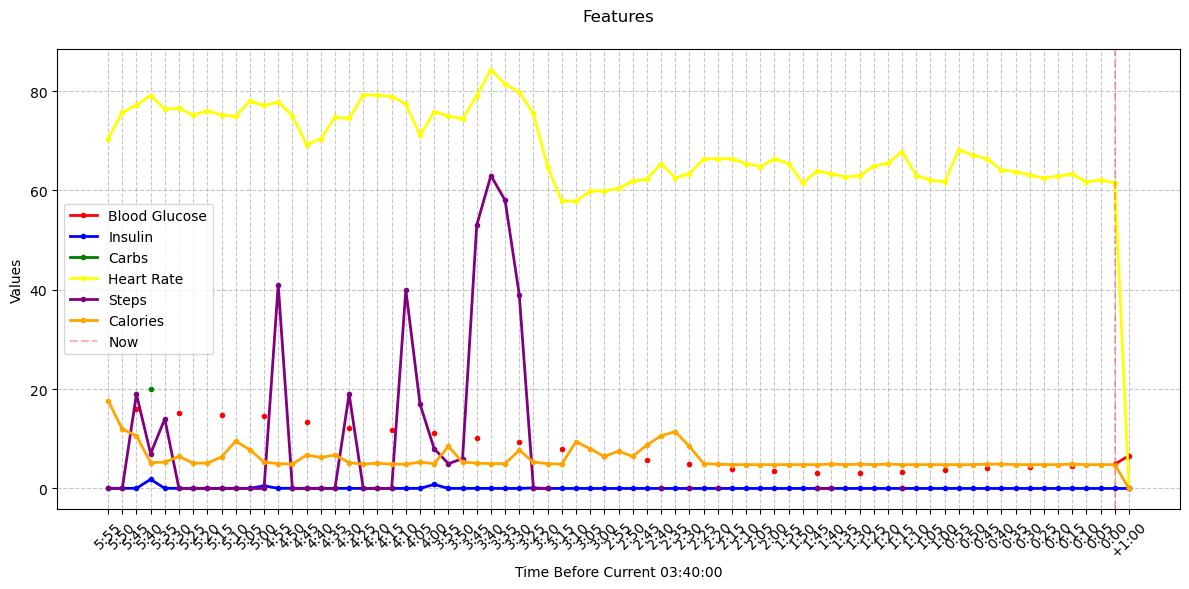

<module 'matplotlib.pyplot' from 'C:\\Users\\Tony\\anaconda3\\envs\\meal_identification\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def get_cols_vals(df, features):
    feature_cols = {}
    feature_vals = {}
    for feature in features:
        # Get cols for this features
        feature_column = sorted(
            [col for col in df.columns if col.startswith(f'{feature}-')],
            key=lambda x: tuple(map(int, x[len(feature)+1:].split(':'))),
            reverse=True
        )
        feature_cols[feature] = feature_column

        # Get the values of the features
        feature_value =  df.iloc[row_index][feature_column].to_numpy()

        if feature == 'bg':
            feature_value = np.append(feature_value, df.iloc[row_index]['bg+1:00'])
        else:
            # Add zero for other features
            feature_value = np.append(feature_value, 0)

        feature_vals[feature] = feature_value

    return feature_cols, feature_vals

def plot_bg_readings(df, row_index=0):
    features = ["bg", "insulin", "carbs", "hr", "steps", "cals"]
    feature_cols, feature_vals = get_cols_vals(df, features)

    # Extract times and values
    times = [col[3:] for col in feature_cols['bg']]
    times.append('+1:00')  # Future time point

    fig, ax = plt.subplots(figsize=(12,6))

    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange']
    labels = ['Blood Glucose', 'Insulin', 'Carbs', 'Heart Rate', 'Steps', 'Calories']

    for idx, feature in enumerate(features):
        ax.plot(times, feature_vals[feature], marker='.', color=colors[idx], linestyle='-',linewidth=2, markersize=6, label=labels[idx])

    current_time = df.iloc[row_index]['time']
    ax.set_title('Features', pad=20, fontsize=12)
    ax.set_xlabel(f'Time Before Current {current_time}', fontsize=10)
    ax.set_ylabel('Values', fontsize=10)

    ax.axvline(x="0:00", color='r', linestyle='--', alpha=0.3, label='Now')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='x', rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return plt

row_index=5000
plot_bg_readings(patient1, row_index=row_index)